# Telecom Churn Analysis

## Overview

Most telecom companies suffer from voluntary churn(loss of customers to a competition). Churn rate has strong impact on the life time value of the customer because it affects the length of service and the future revenue of the company. For example if a company has 25% churn rate then the average customer lifetime is 4 years; similarly a company with a churn rate of 50%, has an average customer lifetime of 2 years. It is estimated that 75 percent of the 17 to 20 million subscribers signing up with a new wireless carrier every year are coming from another wireless provider, which means they are churners. Telecom companies spend hundreds of dollars to acquire a new customer and when that customer leaves, the company not only loses the future revenue from that customer but also the resources spend to acquire that customer. Churn erodes profitability.

Telecom companies have used two approaches to address churn - (a) Untargeted approach and (b) Targeted approach. The untargeted approach relies on superior product and mass advertising to increase brand loyalty and thus retain customers. The targeted approach relies on identifying customers who are likely to churn, and  provide suitable intervention to encourage them to stay.<a name="cite_ref-1"></a>[<sup>[1]</sup>](#cite_note-1)

<a name="cite_note-1"></a>1. [^](#cite_ref-1) Data from CrowdAnalytix, https://www.crowdanalytix.com/contests/why-customer-churn


## Business Understanding

SyriaTel is a smaller end wireless provider, they don't have such the budget to invest in a large scale advertising campaign. However, they also can't afford to keep losing customers. Therefore they have turned to us to create a model for predicting which customers will churn. When a customers has been determined as likely to churn they will contact the customer with promotional deals in hopes of keeping the customer.

In this scenario we will break the data into 2 categories: 1) the columns used to predict churn, 2) the target column of whether the customers churned or not. If churn is "True" that means the customer churned, and "False" if the customer didn't churn. 

In general it is important to consider beforehand whether a false positive or false negative is worse. In each specific case one should tune their model based on what is more important. In our case a false positive means that we predicted the customer would churn when they didn't. The outcome of this is that we will send them some promotional deals, and perhaps give them a discount. This will in turn cause a slight loss of profit, as these clients were already happy paying full price. On the other hand, a false negative is when we predict that a customer won't churn when really they will. This means that we will lose a customer without ever sending them promotional deals to try to get them to stay. The loss from this mistake is far greater then the loss from a false positive. As such when we are creating models we will attempt to minimize false negatives(maximize recall) as much as possible.

<div>
<img src="Images/telephone_poles.jpg", width = 800, height = 400/>
</div>

Photo by <a href="https://unsplash.com/@giggiulena?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Mario Caruso</a> on <a href="https://unsplash.com/photos/0C9VmZUqcT8?utm_source=unsplash&utm_medium=referral&utm_content=creditCopyText">Unsplash</a>
  

## Data Understanding

This public dataset is provided by the CrowdAnalytix community as part of their churn prediction competition. The real name of the telecom company is anonymized, as well as the year of the data. However, it was used in competition in 2012, so seemingly from around then. 

Data source : https://www.crowdanalytix.com/contests/why-customer-churn

Let's do some EDA on the data to find our more about it.

We'll begin by importing all the packages we may need

In [1]:
import pandas as pd
import numpy as np
np.random.seed(42)
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.metrics import precision_score, recall_score,\
classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV,\
cross_val_score, RandomizedSearchCV

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from sklearn.ensemble import VotingClassifier, BaggingClassifier, RandomForestClassifier, \
ExtraTreesClassifier, StackingClassifier, AdaBoostClassifier, GradientBoostingClassifier

import xgboost

# Filtering future warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#Pull up the names of the data files
!ls data

archive.zip                        bigml_59c28831336c6604c800002a.csv


In [3]:
# Read the data as a pandas df, and preview the first 5 columns
df = pd.read_csv('data/bigml_59c28831336c6604c800002a.csv')
df.head()

,state,account length,area code,phone number,international plan,voice mail plan,number vmail messages,total day minutes,total day calls,total day charge,...,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls,churn
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   state                   3333 non-null   object 
 1   account length          3333 non-null   int64  
 2   area code               3333 non-null   int64  
 3   phone number            3333 non-null   object 
 4   international plan      3333 non-null   object 
 5   voice mail plan         3333 non-null   object 
 6   number vmail messages   3333 non-null   int64  
 7   total day minutes       3333 non-null   float64
 8   total day calls         3333 non-null   int64  
 9   total day charge        3333 non-null   float64
 10  total eve minutes       3333 non-null   float64
 11  total eve calls         3333 non-null   int64  
 12  total eve charge        3333 non-null   float64
 13  total night minutes     3333 non-null   float64
 14  total night calls       3333 non-null   

We see that there 20 columns in the dataset. Of which 4 are strings, 15 are integer or float, and 1 is a bool. Most of these are predictor variables for customer usage patterns. The last column, `churn`, is our target column, indicating whether the customer churned or not.

Additionally, there is no missing data, as such there will be very little cleaning necessary.

Let's run a quick check to see if there are any duplicated rows

In [5]:
#check for duplicate rows
df.duplicated().value_counts()

False    3333
dtype: int64

If we take a closer look, we'll notice that although `area code` is listed as integer type, is really is and object, given that a value that is double in area code, doesn't have twice the impact. As such we will convert that column to object

In [6]:
#convert area code from int to object
df['area code'] = df['area code'].astype(object)

#check that it worked
df.dtypes

state                      object
account length              int64
area code                  object
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

Let's move on and take a closer look at the spread of our data

In [7]:
#get descriptive statistics of the df
df.describe()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


Firstly, we see that the data contains 3333 rows of data, which overall isn't such a large sample size. 
- Both the mean and median of `account length` are 101, which tells us that on average each client had their account open for 101 before deciding to terminate it. Unless this is a brand new company, and most of these accounts are still active, they will definitely want to improve this number. 
- It seems that this cellular dataset is from business accounts, as the mean and median number of calls during the day, eve and night were all around 100. While the number of hours on the phone was a little over 3 hours on average. 
- Roughly 5% of these calls were international.
- Most of the clients had made roughly 1-2 service calls to the cellular company over this period.

Let's graph some of these categories using seaborn to see the spread

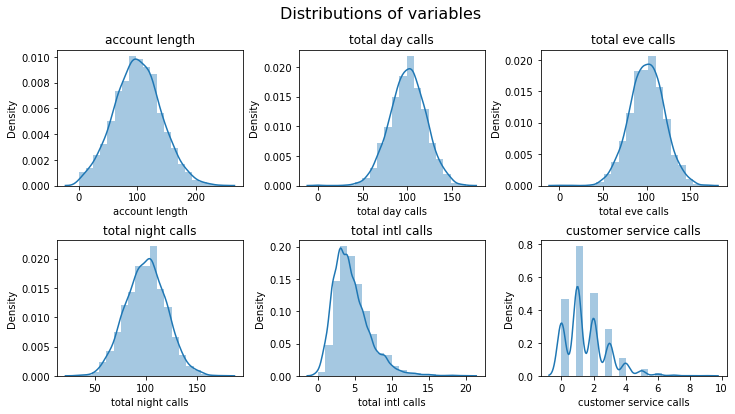

In [8]:
#create list of columns to graph
columns = ['account length', 'total day calls', 'total eve calls', 'total night calls', 
           'total intl calls', 'customer service calls']

#create 2, 3 graphs to plot each column
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12, 6))

# Flatten the subplots array
axs = axs.flatten()
for i, col in enumerate(columns):
    sns.distplot(df[col], bins=20, ax=axs[i])
    axs[i].set_title(col)

# Add a main title to the plot
fig.suptitle('Distributions of variables', fontsize=16)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# Show the plot
plt.show()

Let's move on to take a look at the customer break down by state

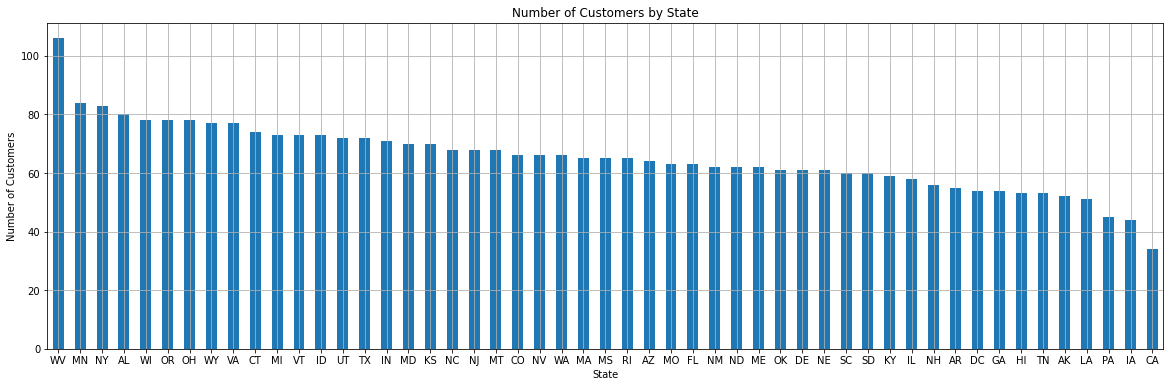

In [9]:
#create bar graph by state
df['state'].value_counts().plot(kind='bar', figsize=(20,6))

# set the title and axis labels
plt.title('Number of Customers by State')
plt.xlabel('State')
plt.ylabel('Number of Customers')

#rotate x label titles
plt.xticks(rotation=0)

#add in gridlines
plt.grid(True)

# display the plot
plt.show()

The number of customers per state ranges from slightly above 100, to slightly below 40. Most states have between 40-80 customers. 

In [10]:
#Check the value counts in the 'area code' column
df['area code'].value_counts()

415    1655
510     840
408     838
Name: area code, dtype: int64

Quite strange that all the area codes are in California; however, the dataframe is composed of a lot of non California states. 

Finally, lets take a look at our `churn` column

False    2850
True      483
Name: churn, dtype: int64


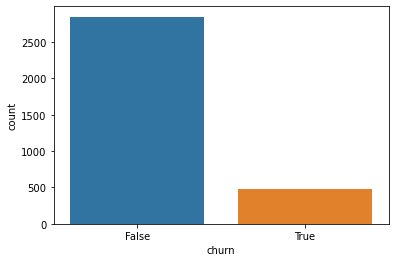

In [11]:
# Countplot of churn feature
print(df.churn.value_counts())
sns.countplot(data=df, x='churn');

In [12]:
#print out the churn percentage
churn_counts = df.churn.value_counts(normalize=True)
print(f'Percent of customers that churned: {int(round(churn_counts[1]*100))}%')

Percent of customers that churned: 14%


Lastly, let's print out the churn percentage by `state`, `international plan`, and `voice mail plan` to see if there is anything interesting there

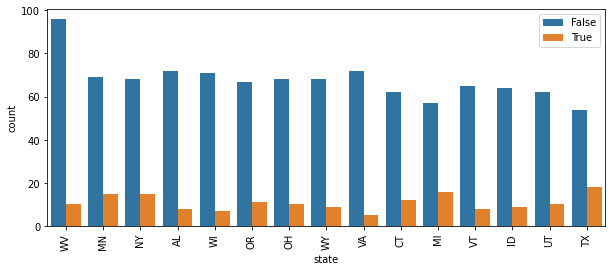

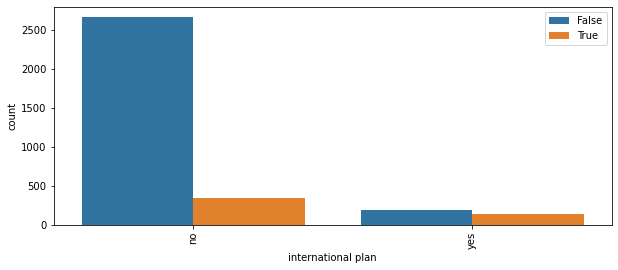

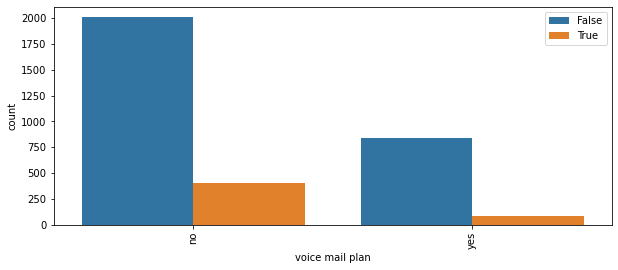

In [13]:
#create list of columns to graph
columns = ['state', 'international plan', 'voice mail plan']

#for loop thru columns
for col in columns:
    
    #create figure
    plt.figure(figsize=(10,4))
    
    #create countplot for each column, broken up by churn
    sns.countplot(x=col, hue="churn", data=df,order= df[col].value_counts().iloc[0:15].index)
    
    #rotate xticks to 90 degrees
    plt.xticks(rotation=90)
    
    #insert a legend in the top right hand corner
    plt.legend(loc="upper right")
    plt.show()

There's to be nothing major that stands out here. Most states seem to have similar churn percentages. Similarly, those without and without voice mail plans also have similar churn percentages. However, it is interesting to not that the percent churn on those with international plans, was far greater then those without. Although, the amount of people with international plans was quite small and thus it's a small sample size, it is still an interesting observation

## Data Preperation

If we take a closer look, we'll notice that although `area code` is listed as integer type, it really is an object. This is because a value that is double in area code, doesn't have twice the impact. As such we will convert that column to object

In [14]:
#convert area code from int to object
df['area code'] = df['area code'].astype(object)

#check that it worked
df.dtypes

state                      object
account length              int64
area code                  object
phone number               object
international plan         object
voice mail plan            object
number vmail messages       int64
total day minutes         float64
total day calls             int64
total day charge          float64
total eve minutes         float64
total eve calls             int64
total eve charge          float64
total night minutes       float64
total night calls           int64
total night charge        float64
total intl minutes        float64
total intl calls            int64
total intl charge         float64
customer service calls      int64
churn                        bool
dtype: object

Since the phone number that someone happens to have should have zero correlation with whether they churn or not, we will drop that column.

In [15]:
#drop phone number column
df.drop('phone number', axis = 1, inplace=True)

Now, let's move on to our data analysis

## Data Analysis

We begin by splitting our data into predictors and target columns. The target column is `churn` and the predictors will be the other columns in the df

In [16]:
#split the data into X and y, based on predictors and target
y = df.churn
X = df.drop(['churn'], axis = 1)

Let's split the data into 2 groups to create a model on the training data, and then test it back on the other part of the data

In [17]:
# run a train test split, to split the data with a test size of 20%
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

### Data Preprocessing
To prepare our data for analysis we need to create dummy variables for the categorical data and scale the numerical predictors

In [18]:
#create a df of all categorical predictors
X_train_cat = X_train.select_dtypes('object')

#create a OneHotEncoder to create dummy columns
ohe = OneHotEncoder(drop='first', sparse=False)

#fit the encoder on the data and transform it
dums = ohe.fit_transform(X_train_cat)

#turn the numpy array back into a pandas df
dums_df = pd.DataFrame(dums, columns=ohe.get_feature_names(), index=X_train_cat.index)

#preview the df to confirm it loaded correctly
dums_df.head()

,x0_AL,x0_AR,x0_AZ,x0_CA,x0_CO,x0_CT,x0_DC,x0_DE,x0_FL,x0_GA,...,x0_VA,x0_VT,x0_WA,x0_WI,x0_WV,x0_WY,x1_415,x1_510,x2_yes,x3_yes
817,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1373,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
56,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1993,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [19]:
#create df of categorical values in X_train
X_train_nums = X_train.select_dtypes(['int64', 'float64'])

#initiate a StandardScaler()
ss = StandardScaler()

#fit the scaler
ss.fit(X_train_nums)

#convert the numpy array back to a pandas df
nums_df = pd.DataFrame(ss.transform(X_train_nums), columns=X_train_nums.columns, 
                       index=X_train_nums.index)

#preview the data
nums_df.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
817,3.601382,-0.584936,-1.547653,-0.429657,-1.547170,-0.729987,-1.840891,-0.731087,1.255804,0.925634,1.256197,-1.300791,0.634849,-1.304132,0.318978
1373,0.184951,-0.584936,-1.244014,0.224176,-1.244071,-0.138082,0.499864,-0.139179,0.165090,-0.353704,0.164841,-2.194793,-0.184370,-2.191525,1.813519
679,-0.650176,-0.584936,0.787609,-1.133785,0.787772,2.491952,0.549667,2.493068,0.147339,0.209205,0.147309,-0.549828,1.863677,-0.549186,-0.428293
56,1.020079,-0.584936,-0.969818,-0.127888,-0.970200,-0.408385,-1.890695,-0.408439,-1.178086,1.437368,-1.176344,-0.800149,-1.003589,-0.800835,-0.428293
1993,-0.371801,-0.584936,0.675354,-0.228477,0.675192,1.294330,-1.143645,1.295326,0.265680,0.516246,0.265649,-2.051753,-0.593980,-2.045833,-1.175564


In [20]:
#create a df that combines the numeric and categorical predictors
X_train_clean = pd.concat([nums_df, dums_df], axis=1)

#preview the df
X_train_clean.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,x0_VA,x0_VT,x0_WA,x0_WI,x0_WV,x0_WY,x1_415,x1_510,x2_yes,x3_yes
817,3.601382,-0.584936,-1.547653,-0.429657,-1.547170,-0.729987,-1.840891,-0.731087,1.255804,0.925634,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1373,0.184951,-0.584936,-1.244014,0.224176,-1.244071,-0.138082,0.499864,-0.139179,0.165090,-0.353704,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
679,-0.650176,-0.584936,0.787609,-1.133785,0.787772,2.491952,0.549667,2.493068,0.147339,0.209205,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
56,1.020079,-0.584936,-0.969818,-0.127888,-0.970200,-0.408385,-1.890695,-0.408439,-1.178086,1.437368,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1993,-0.371801,-0.584936,0.675354,-0.228477,0.675192,1.294330,-1.143645,1.295326,0.265680,0.516246,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [21]:
#create df of categorical predictors in X_test
X_test_cat = X_test.select_dtypes('object')

#use the OneHotEncoder() to create dummy columns
test_dums = ohe.transform(X_test_cat)

#convert the numpy array back to a pandas df
test_dums_df = pd.DataFrame(test_dums, columns=ohe.get_feature_names(), index=X_test_cat.index)

In [22]:
#create df of numeric predictors in X_test
X_test_nums = X_test.select_dtypes(['int64','float64'])

#use StandardScaler() to scale the data
test_nums = ss.transform(X_test_nums)

#convert the numpy array back to a pandas df
test_nums_df = pd.DataFrame(test_nums, columns=X_test_nums.columns, index=X_test_nums.index)

In [23]:
nums_df.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,total night charge,total intl minutes,total intl calls,total intl charge,customer service calls
817,3.601382,-0.584936,-1.547653,-0.429657,-1.547170,-0.729987,-1.840891,-0.731087,1.255804,0.925634,1.256197,-1.300791,0.634849,-1.304132,0.318978
1373,0.184951,-0.584936,-1.244014,0.224176,-1.244071,-0.138082,0.499864,-0.139179,0.165090,-0.353704,0.164841,-2.194793,-0.184370,-2.191525,1.813519
679,-0.650176,-0.584936,0.787609,-1.133785,0.787772,2.491952,0.549667,2.493068,0.147339,0.209205,0.147309,-0.549828,1.863677,-0.549186,-0.428293
56,1.020079,-0.584936,-0.969818,-0.127888,-0.970200,-0.408385,-1.890695,-0.408439,-1.178086,1.437368,-1.176344,-0.800149,-1.003589,-0.800835,-0.428293
1993,-0.371801,-0.584936,0.675354,-0.228477,0.675192,1.294330,-1.143645,1.295326,0.265680,0.516246,0.265649,-2.051753,-0.593980,-2.045833,-1.175564


In [24]:
#create a new test df with the numeric and categorical predictors
X_test_clean = pd.concat([test_nums_df, test_dums_df], axis=1)

#preview the final test df
X_test_clean.head()

,account length,number vmail messages,total day minutes,total day calls,total day charge,total eve minutes,total eve calls,total eve charge,total night minutes,total night calls,...,x0_VA,x0_VT,x0_WA,x0_WI,x0_WV,x0_WY,x1_415,x1_510,x2_yes,x3_yes
438,0.311486,-0.584936,-0.452712,-0.379362,-0.452767,2.562980,0.300651,2.562705,-0.219520,1.181501,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2674,-0.852632,-0.584936,-1.297381,0.827714,-1.297113,0.329524,1.197110,0.329704,-0.239243,2.102624,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1345,-0.068118,-0.584936,-3.305080,-5.056782,-3.305141,-0.810881,1.495930,-0.810008,-0.659356,-0.609571,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1957,1.171920,-0.584936,0.610946,-1.083490,0.611325,0.067112,-0.446399,0.067408,-0.874343,0.669766,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2148,-0.118732,-0.584936,-0.655138,0.073292,-0.655194,0.473554,-1.342858,0.473619,0.535893,-0.456051,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


Now that we have our data ready to go, let's begin our modeling.

## Modeling
### Logistic Regression
We'll begin our modeling with a baseline model using a Logistic Regression model. This works by adjusting the coefficients of the predictors using gradient descent. Which attempts to minimize the difference between predicted probabilities and the binary values.

In [25]:
#Initiate LogisticRegression with random_state of 42 for reproduction
lr = LogisticRegression(random_state=42)

#fit the regressor to our preprocessed data
lr.fit(X_train_clean, y_train)

LogisticRegression(random_state=42)

Let's split up the training data into folds and test the accuracy of the regressor on the data

In [26]:
#run cross_val_scores using our LogisticRegressor, using 10 folds
scores = cross_val_score(estimator=lr, X = X_train_clean, y= y_train, cv=10)

#preview the scores
scores

array([0.86142322, 0.86891386, 0.87265918, 0.86516854, 0.86142322,
       0.86142322, 0.84210526, 0.84962406, 0.84586466, 0.87593985])

In [27]:
#pull up the median score
np.median(scores)

0.8614232209737828

Now let's test our on model on the testing data

In [28]:
#test our model on the test data
lr.score(X_test_clean, y_test)

0.8530734632683659

Given an accuracy within one of our training data, we see that there isn't an issue of overfitting here. Before moving on to try to improve our model, let's do the same thing in a pipeline to make the code more manageable. 

### Logistic Regression Pipeline

In [29]:
#create df with categorical predictors
df_cat = X_train.select_dtypes(include=['object'])

# create df with numeric predictors
df_num = X_train.select_dtypes(include=['int64', 'float64'])

In [30]:
#initiate a pipeline using scaler for our numeric df
num_pipe = Pipeline(steps=[('ss', StandardScaler())])

#initiate a pipeline using ohe for our categorical df
cat_pipe = Pipeline(steps=[('ohe', OneHotEncoder(drop='first', sparse=False))])

# create a transformer that combines these pipelines
transformer = ColumnTransformer(transformers=[
    ('numerical', num_pipe, df_num.columns),
    ('categorical', cat_pipe, df_cat.columns)
])

In [31]:
#combine the transformer with our regression model into a new pipeline
model_pipe_lr = Pipeline(steps=[
    ('transformer', transformer),
    ('lr', LogisticRegression(random_state=42))
])

#fit the pipeline on the data
model_pipe_lr.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 s

In [32]:
# get the accuracy score of the model
model_pipe_lr.score(X_train, y_train)

0.872093023255814

In [33]:
#get the model score on our testing dataset
model_pipe_lr.score(X_test, y_test)

0.8530734632683659

Let's move on to create our next model

### KNN

This model makes predictions on the new data based on its similarity to the existing "nearby" data. We will be using a classifier as the the target variable is categorical.

In [34]:
#initiate KNeighborsClassifier()
knn = KNeighborsClassifier()

#fit the classifier
knn.fit(X_train_clean, y_train)

KNeighborsClassifier()

In [35]:
#run cross_val_scores using our knn, using 10 folds
scores = cross_val_score(estimator=knn, X = X_train_clean, y= y_train, cv=10)

#preview the score
scores

array([0.87640449, 0.86516854, 0.88764045, 0.88389513, 0.88389513,
       0.89138577, 0.86842105, 0.87218045, 0.87969925, 0.90225564])

In [36]:
#pull up median score
np.median(scores)

0.8817971896032215

In [37]:
#see how it runs on the testing data
knn.score(X_test_clean, y_test)

0.8935532233883059

Since this is very similar to the score for the training data we can say that the model is not overfitting.

Let's now run a GridSearch to test out what the optimal model would be for our data

In [38]:
#create grid, with different neighbor, metric, and weight options
grid = {
    'n_neighbors': [3 ,5 , 11],
    'metric': ['manhattan', 'minkowski'],
    'weights': ['uniform', 'distance']
}

In [39]:
#initiate the GridSearchCV()
gs = GridSearchCV(estimator=knn, param_grid= grid, cv=5)

In [40]:
#fit the gs
gs.fit(X_train_clean, y_train)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'metric': ['manhattan', 'minkowski'],
                         'n_neighbors': [3, 5, 11],
                         'weights': ['uniform', 'distance']})

In [41]:
#pull up the best parameters
gs.best_params_

{'metric': 'minkowski', 'n_neighbors': 5, 'weights': 'uniform'}

This happens to be the same as our default/ original model

In [42]:
#run the model on our testing set and pull up the score
gs.best_estimator_.score(X_test_clean, y_test)

0.8935532233883059

### Pipeline for knn
Again lets create a pipeline for the above

In [43]:
#create pipeline with transformer and knn
model_pipe_knn = Pipeline(steps=[
    ('transformer', transformer),
    ('knn', KNeighborsClassifier())
])

#fit the pipeline on X_train
model_pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 s

In [44]:
# get the accuracy score for the pipeline
model_pipe_knn.score(X_train, y_train)

0.9036009002250562

In [45]:
# get the score of the pipeline on the testing data
model_pipe_knn.score(X_test, y_test)

0.8935532233883059

In [46]:
#create a grid for a grid search for the pipeline
param_grid = {
    'knn__n_neighbors': [3, 5, 11],
    'knn__metric': ['manhattan', 'minkowski'],
    'knn__weights': ['uniform', 'distance']
}

#initiate the gridsearch with 5 folds
gs = GridSearchCV(model_pipe_knn, param_grid=param_grid, cv=5)

# fit the gs
gs.fit(X_train, y_train)

#pull up the best parameters
gs.best_params_

{'knn__metric': 'manhattan', 'knn__n_neighbors': 3, 'knn__weights': 'uniform'}

In [47]:
# run the model on the testing data
gs.best_estimator_.score(X_test, y_test)

0.8875562218890555

Now let's create a Decision Tree Classifier

### Decision Trees
The model predicts based on splitting the data into nodes based on features. At each node the data selected the feature that best splits the data based on criterion chosen.

In [48]:
#initiate classifier
clf = DecisionTreeClassifier(random_state=42)

#fit the classifier
clf.fit(X_train_clean, y_train)

DecisionTreeClassifier(random_state=42)

In [49]:
#get score on the training data
clf.score(X_train_clean, y_train)

1.0

In [50]:
#pull up score for the test data
clf.score(X_test_clean, y_test)

0.9280359820089955

Although, this decision tree was slightly overfit it still has been the best predictor yet.

In [51]:
#create grid for grid search
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 3, 5, 7, 9],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

In [52]:
#initiate gs
gs = GridSearchCV(clf, param_grid=param_grid, cv=5)

In [53]:
#fit the gs
gs.fit(X_train_clean, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 3, 5, 7, 9],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10]})

In [54]:
#pull up best parameters
gs.best_params_

{'criterion': 'entropy',
 'max_depth': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 10}

In [55]:
# run the gs on the test data
gs.best_estimator_.score(X_test_clean, y_test)

0.9385307346326837

Let's again create a pipeline for the above process
### Pipeline for Decision Tree

In [56]:
# initiate pipeline with tranformer and Decision Tree
model_pipe_tree = Pipeline(steps=[
    ('transformer', transformer),
    ('dt', DecisionTreeClassifier(random_state=42))
]) 

In [57]:
#fit the pipeline
model_pipe_tree.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('numerical',
                                                  Pipeline(steps=[('ss',
                                                                   StandardScaler())]),
                                                  Index(['account length', 'number vmail messages', 'total day minutes',
       'total day calls', 'total day charge', 'total eve minutes',
       'total eve calls', 'total eve charge', 'total night minutes',
       'total night calls', 'total night charge', 'total intl minutes',
       'total intl calls', 'total intl charge', 'customer service calls'],
      dtype='object')),
                                                 ('categorical',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 s

In [58]:
#score the pipeline on the training data
model_pipe_tree.score(X_train, y_train)

1.0

In [59]:
# score the pipeline on the testing data
model_pipe_tree.score(X_test, y_test)

0.9280359820089955

In [60]:
# Define the grid to search over
param_grid = {
    'dt__criterion': ['gini', 'entropy'],
    'dt__max_depth': [None, 3, 5, 7, 9],
    'dt__min_samples_split': [2, 5, 10],
    'dt__min_samples_leaf': [1, 2, 4],
}

In [61]:
# Create a GridSearch object
grid_search = GridSearchCV(
    estimator=model_pipe_tree,
    param_grid=param_grid,
    cv=5,
    n_jobs=-1
)

# Fit the gs to the training data
grid_search.fit(X_train, y_train)

# Print the best hyperparameters and corresponding score
print("Best parameters: ", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)

Best parameters:  {'dt__criterion': 'entropy', 'dt__max_depth': 7, 'dt__min_samples_leaf': 2, 'dt__min_samples_split': 10}
Best score:  0.9403594943468881


Let's move on to another classifier

### Voting Classifier

This classifier combines all the above predictors, fits each one on the data, and then uses the majority prediction as its final prediction

In [62]:
#initiate the VotingClassifier() using logistic regression, knn, and DecisionTree
w_avg = VotingClassifier(estimators=[
    ('lr', LogisticRegression()), 
    ('knn', KNeighborsClassifier(metric= 'minkowski', 
                                 n_neighbors= 5, 
                                 weights= 'uniform')),
    ('dt', DecisionTreeClassifier(criterion= 'entropy',
                                  max_depth= 7,
                                  min_samples_leaf= 2,
                                  min_samples_split= 10))
])

#fit the predictor
w_avg.fit(X_train_clean, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('knn', KNeighborsClassifier()),
                             ('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=7,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10))])

In [63]:
#Run a cross_val_score with 5 folds, on the model. Then preview the scores
scores = cross_val_score(estimator=w_avg, X=X_train_clean, y=y_train, cv=5)
scores

array([0.89513109, 0.89868668, 0.90243902, 0.87617261, 0.9043152 ])

In [64]:
#pull up the median score
np.median(scores)

0.8986866791744841

In [65]:
# score the model on the training data
w_avg.score(X_train_clean, y_train)

0.9208552138034508

In [66]:
# score the model on the testing data
w_avg.score(X_test_clean, y_test)

0.9070464767616192

Given that DecisionTree is the best model of all 3, let's try and rerun the model with re-weighting. Meaning we will give more vote to the decision tree model in prediction the results

In [67]:
# re-initiate model with new weights: lr: .2, knn: .3, and dt: .5
w_avg = VotingClassifier(estimators=[
    ('lr', LogisticRegression()), 
    ('knn', KNeighborsClassifier(metric= 'minkowski', 
                                 n_neighbors= 5, 
                                 weights= 'uniform')),
    ('dt', DecisionTreeClassifier(criterion= 'entropy',
                                  max_depth= 7,
                                  min_samples_leaf= 2,
                                  min_samples_split= 10))],
    weights=[.2, .3, .5]
)

#fit the model on the training data
w_avg.fit(X_train_clean, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression()),
                             ('knn', KNeighborsClassifier()),
                             ('dt',
                              DecisionTreeClassifier(criterion='entropy',
                                                     max_depth=7,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10))],
                 weights=[0.2, 0.3, 0.5])

In [68]:
#score the model on the training data
w_avg.score(X_train_clean, y_train)

0.9204801200300075

In [69]:
#score the model on the testing data
w_avg.score(X_test_clean, y_test)

0.9055472263868066

So far our best model has been DecisionTreeClassifier with the following parameters:
- Criterion: 'entropy'
- max_depth: 7
- min_samples_leaf: 2
- min_samples_split: 10

With an accuracy of .94 on the testing set

Before we move on let's check out the classification report of this model.

In [70]:
#re-initiate the model with desired conditions
dt = DecisionTreeClassifier(criterion='entropy', 
                            max_depth=7, 
                            min_samples_leaf=2, 
                            min_samples_split=10,
                            random_state=42)
#fit the model
dt.fit(X_train_clean, y_train)

#create prediction variables for the testing set
y_preds = dt.predict(X_test_clean)

#create a classification_report using actual results vs predicted results
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

       False       0.95      0.98      0.96       566
        True       0.85      0.72      0.78       101

    accuracy                           0.94       667
   macro avg       0.90      0.85      0.87       667
weighted avg       0.94      0.94      0.94       667



Now lets move on to create a bagging model

### Bagging

Bagging, which is short for Bootstrap Aggregating, is an ensemble method that creates multiple versions of a base model on different subsets of the training data and combining their predictions. The samples are created by bootstrap sampling, which is a random sampling technique that involves selecting samples from the training set with replacement. The sample uses n_estimators as a hyperparameter which determines how many base estimators(Decision Trees) to run on the subset of the data 

In [171]:
#initiate the BaggingClassifier with n_estimators=100, random_state=42
bag = BaggingClassifier(n_estimators=100, random_state=42)

In [172]:
#fit the model
bag.fit(X_train_clean, y_train)

BaggingClassifier(n_estimators=100, random_state=42)

In [173]:
#pul up scores of the model on 5 folds
scores = cross_val_score(estimator=bag, X=X_train_clean, y=y_train, cv=5)
scores

array([0.94569288, 0.94559099, 0.93621013, 0.94183865, 0.9587242 ])

In [174]:
#get the median score
np.median(scores)

0.9455909943714822

In [175]:
#score the model on the training data
bag.score(X_test_clean, y_test)

0.9535232383808095

Since this is our best model yet, let's pull up a classification_report of the model

In [176]:
#create predictions for our testing test
y_pred = bag.predict(X_test_clean)

#create classification_report based on predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.99      0.97       566
        True       0.93      0.75      0.83       101

    accuracy                           0.95       667
   macro avg       0.94      0.87      0.90       667
weighted avg       0.95      0.95      0.95       667



So now we have a model with 95% accuracy, 93% precision, and an f1 score of .83, our best model yet! However, our recall is only 75%. Let's try to tweak this model to improve the recall, without decreasing the precision and f1 score too much.

In [177]:
#store values for predicted probabilities for the True class
y_prob = bag.predict_proba(X_test_clean)[:,1]

#create prediction based on a new threshold of .29
y_pred = (y_prob >= 0.29).astype(int)

#create a classification_report and name it bag_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.96      0.96       566
        True       0.78      0.84      0.81       101

    accuracy                           0.94       667
   macro avg       0.88      0.90      0.89       667
weighted avg       0.94      0.94      0.94       667



In [178]:
#print confusion matrix
print(confusion_matrix(y_test, y_pred))

[[542  24]
 [ 16  85]]


The best we can do without changing the model too much is a recall of .84 while only decreasing the accuracy by 1% and f1 score by .2. Although, the precision decreased by 15%, for this stakeholder this is a better model. Additionally, many other probabilities were tested, and this was the best balance. 

Let's run a GridSearch for multiple features to see if the model can do better.

In [179]:
#reset BaggingClassifier with random_state=42
grid_bag = BaggingClassifier(random_state=42)

#create param grid
params = {
    'n_estimators': [10, 50, 100],
    'max_samples': [0.5, 1.0],
}


#I previously ran this cell with: 'max_features': [0.5, 1.0], 'bootstrap': [True, False]
# and they returned the default answers. Due to the time it took to run the cell, 
#I removed them from the notebook

In [180]:
#create the GridSearchCV with 5 folds
grid = GridSearchCV(grid_bag, param_grid=params, cv=5)

#fit the grid on the training data
grid.fit(X_train_clean, y_train)

GridSearchCV(cv=5, estimator=BaggingClassifier(random_state=42),
             param_grid={'max_samples': [0.5, 1.0],
                         'n_estimators': [10, 50, 100]})

In [181]:
#print the best parameters
print(grid.best_params_)

{'max_samples': 0.5, 'n_estimators': 50}


In [182]:
#score the model on the training data
grid.best_estimator_.score(X_train_clean, y_train)

0.9756189047261815

In [183]:
#score the model on the test data
grid.best_estimator_.score(X_test_clean, y_test)

0.9505247376311844

In [191]:
#store values for predicted probabilities for the True class
y_prob = grid.predict_proba(X_test_clean)[:,1]

#create prediction based on a new threshold of .29
y_pred = (y_prob >= 0.24).astype(int)

#create a classification_report and name it bag_report
bag_report = classification_report(y_test, y_pred)

#print the report
print(bag_report)

              precision    recall  f1-score   support

       False       0.97      0.94      0.96       566
        True       0.73      0.85      0.79       101

    accuracy                           0.93       667
   macro avg       0.85      0.90      0.87       667
weighted avg       0.94      0.93      0.93       667



Although our accuracy went down 1% from our previous model, as well as precision dropping another 5%. The recall increased 1% without having too much of an affect on the f1 score. The f1 score only decreased by .02, to .79, which is still an acceptable value. 

We will come back to this model later, as it is our best model so far.

### Random Forest

RandomForestClassifier() is made up of a large amount of decision trees. These trees are created by randomly selecting part of the data and randomly selecting features. Then the best possible decision tree is made on this subset of the data. This is done until a prespecified number of trees are made. Then the final model creates a prediction based on the majority of trees.

In [135]:
#initiate RandomForestClassifier()
rfc = RandomForestClassifier(max_features='sqrt', max_samples=.5, random_state=42)

#fit the classifier on the train data
rfc.fit(X_train_clean, y_train)

RandomForestClassifier(max_features='sqrt', max_samples=0.5, random_state=42)

In [136]:
# pull up 5 folds of scores using cross_val_score
scores = cross_val_score(rfc, X_train_clean, y_train, cv=5)
scores

array([0.91011236, 0.93245779, 0.91932458, 0.90994371, 0.92120075])

In [137]:
#get the median
np.median(scores)

0.9193245778611632

In [138]:
#calculate the score on the training set
score = rfc.score(X_test_clean, y_test)
score

0.9295352323838081

In [139]:
#predict scores for our test set
y_pred = rfc.predict(X_test_clean)

#print out a classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.92      1.00      0.96       566
        True       0.98      0.54      0.70       101

    accuracy                           0.93       667
   macro avg       0.95      0.77      0.83       667
weighted avg       0.93      0.93      0.92       667



While the precision is quite high, the recall is really low.

Let's move on and check out an ExtraTrees model

### Extra Trees 

ExtraTrees is similar to Random Forests in that it builds multiple decision trees and then combines their predictions. However, it differs in how it creates those Decision Trees, in that Extra Trees creates decision trees much more randomly then Random Forest. As such we should expect a lower score here the Random Forests

In [85]:
#Initiate ExtraTreesClassifier
etr = ExtraTreesClassifier(max_features='sqrt', 
                          max_samples=.5,
                          bootstrap=True,
                          random_state=42)

We ran a GridSearchCV to find out the best features to run the ExtraTrees with

In [115]:
#Fit the classifier on the training data
etr.fit(X_train_clean, y_train)

ExtraTreesClassifier(bootstrap=True, max_features='sqrt', max_samples=0.5,
                     random_state=42)

In [116]:
#score the classifier on 5 folds on the train set
scores = cross_val_score(etr, X_train_clean, y_train, cv=5)
scores

array([0.88014981, 0.88742964, 0.89305816, 0.87804878, 0.88930582])

This is not great, so lets move on.

### Stacking

Stacking Classifier  combines multiple models to make a final prediction. The combination of these models is done in two stages.  In the first stage, the base models make predictions based on the training data. The higher level model uses these predictions to make a final prediction on the data.

In [121]:
#input LogisticRegression, KNearestNeighbors and DecisionTrees as our estimators
estimators = [
    ('lr', LogisticRegression()),
    ('kkn', KNeighborsClassifier()),
    ('dt', DecisionTreeClassifier())
]

#initiate Stacking Classifier
sr = StackingClassifier(estimators)

#fit it to the data
sr.fit(X_train_clean, y_train)

StackingClassifier(estimators=[('lr', LogisticRegression()),
                               ('kkn', KNeighborsClassifier()),
                               ('dt', DecisionTreeClassifier())])

In [122]:
#score the classifier on the training set
sr.score(X_train_clean, y_train)

0.9879969992498124

In [123]:
# score the classifier on the testing set
sr.score(X_test_clean, y_test)

0.9370314842578711

In [125]:
#create predictions for the testing set
y_pred = sr.predict(X_test_clean)

#create a classification_report based on the predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.94      0.99      0.96       566
        True       0.90      0.65      0.76       101

    accuracy                           0.94       667
   macro avg       0.92      0.82      0.86       667
weighted avg       0.94      0.94      0.93       667



Again, while the overall model is very good, the recall and f1 score are much lower then we need it to be. Let's move on to our next model

### Adaboost

Adaboost works by combining multiple weak classifiers, that are slightly better than random guessing, into one final model. This is done by training a weak classifier on the training data. Then the classifier increases the weights of the misclassified data, and creates a new weak classifier on the updated data. This is done until a prespecified number of classifiers have been made. These weak classifiers are combined into one final strong classifier.

In [92]:
#Initiate AdaBoostClassifier()
abc = AdaBoostClassifier()

#fit the Classifier()
abc.fit(X_train_clean, y_train)

AdaBoostClassifier()

In [93]:
#score the classifier on the training set
abc.score(X_train_clean, y_train)

0.8934733683420856

In [94]:
# create prediction variables on the testing set
y_pred = abc.predict(X_test_clean)

# create classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.89      0.97      0.93       566
        True       0.65      0.34      0.44       101

    accuracy                           0.87       667
   macro avg       0.77      0.65      0.69       667
weighted avg       0.86      0.87      0.85       667



This is not great so let's move on to the next predictor.

### Gradient Boost

Gradient Boost is done by training a weak learner on the data. Then calculating the residuals, and training a model on those residuals. This, is done a specified number of times, then these weak learners are all combined using weighted majority voting to create one strong learner.

In [95]:
# Initiate GradientBoostingClassifier with specified features from a GridSearch
gbc = GradientBoostingClassifier(max_depth=2, n_estimators=3, learning_rate=1.0)

#fit the classifier
gbc.fit(X_train_clean, y_train)

GradientBoostingClassifier(learning_rate=1.0, max_depth=2, n_estimators=3)

In [96]:
# score the classifier on the training set
gbc.score(X_train_clean, y_train)

0.9017254313578394

In [126]:
# create prediction values on the testing set
y_pred = gbc.predict(X_test_clean)

#print a classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.90      0.99      0.94       566
        True       0.84      0.42      0.56       101

    accuracy                           0.90       667
   macro avg       0.87      0.70      0.75       667
weighted avg       0.89      0.90      0.88       667



Since this is not nearly as good as previous models, we will move on to our final type of model.

### XGBoost

XGBoost can be thought of as an improved version of Gradient Boosting as it uses very similar techniques to model but with some enhancements. It works by training weak learners, using gradient descent, to minimize the loss function. Each new learner is trained to correct the previous predictor's error. The final model is a weighted combination of all the trees based on its reduction to the loss function.

In [127]:
#Initiate XGBoost
xgb = xgboost.XGBClassifier(random_state=42, objective='reg:squarederror')

#fit the classifier
xgb.fit(X_train_clean, y_train)

#'gamma': 0.1, 'max_depth': 4,

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='reg:squarederror', random_state=42, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [112]:
#score the model on training set
xgb.score(X_train_clean, y_train)

1.0

In [128]:
#create predictions for X_test
y_pred = xgb.predict(X_test_clean)

#create a classification_report based on predictions
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.96      0.98      0.97       566
        True       0.89      0.76      0.82       101

    accuracy                           0.95       667
   macro avg       0.92      0.87      0.89       667
weighted avg       0.95      0.95      0.95       667



This default is very similar to our bag(which was our best model so far). The accuracy in the bag was 95% with a recall of 75%, precision of 93%, and recall of .83. This model has the same accuracy with a slightly worse precision and f1 score and slightly better recall. Just as we tweaked our bag model, let's try to tweak our current model to improve the recall without decreasing the precision and f1 score too much.

In [134]:
#store values for predicted probabilities for the True class
y_prob = xgb.predict_proba(X_test_clean)[:,1]

#create predictions for X_test based on probability of .25
y_pred = (y_prob >= 0.25).astype(int)

#print clasification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

       False       0.97      0.95      0.96       566
        True       0.75      0.84      0.79       101

    accuracy                           0.93       667
   macro avg       0.86      0.90      0.88       667
weighted avg       0.94      0.93      0.94       667



Let's pull up our previous best model(which was made using bagging), to compare scores

In [193]:
#print classification_report for our previous best model
print(bag_report)

              precision    recall  f1-score   support

       False       0.97      0.94      0.96       566
        True       0.73      0.85      0.79       101

    accuracy                           0.93       667
   macro avg       0.85      0.90      0.87       667
weighted avg       0.94      0.93      0.93       667



Our bagging model still remains our best model as it has the same f1 score and accuracy, yet has a higher recall score by 1% with only a slightly lower precision.

Let's run a grid sesarch to see if we can improve the model

In [194]:
#set params for grid search
param_grid = {
    "max_depth": [4, 6, 8],
    "gamma": [0, 0.1, 0.5]
}

# Create GridSearchCV object
grid_search = GridSearchCV(xgb, param_grid=param_grid, cv=5, n_jobs=-1)

# Fit the GridSearchCV object on training data
grid_search.fit(X_train_clean, y_train)

#the param_grid originally contained more features. However, they ended up all suggesting
# that the default settings were the best. As such we removed them from the grid as it
# took a very long time to run. These included: learning_rate, n_estimators

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0, gpu_id=-1,
                                     importance_type='gain',
                                     interaction_constraints='',
                                     learning_rate=0.300000012,
                                     max_delta_step=0, max_depth=6,
                                     min_child_weight=1, missing=nan,
                                     monotone_constraints='()',
                                     n_estimators=100, n_jobs=0,
                                     num_parallel_tree=1,
                                     objective='reg:squarederror',
                                     random_state=42, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, subsample=1,
                      

In [195]:
#find best_params_
grid_search.best_params_

{'gamma': 0.1, 'max_depth': 4}

In [196]:
#score the model on the training data
grid_search.score(X_train_clean, y_train)

0.9804951237809453

In [197]:
#store values for predicted probabilities for the True class
y_prob = xgb.predict_proba(X_test_clean)[:,1]

#create predictions for the testing set using a threshold of .25
y_pred = (y_prob >= 0.25).astype(int)

#print classification_report
print(classification_report(y_test, y_pred))

#other probabilities were testing here, and this created the best balance of the scores

              precision    recall  f1-score   support

       False       0.97      0.95      0.96       566
        True       0.75      0.84      0.79       101

    accuracy                           0.93       667
   macro avg       0.86      0.90      0.88       667
weighted avg       0.94      0.93      0.94       667



## get best model from end of bag section

In [203]:
#put this on final model
feat_import = {name:score
               for name, score
                   in zip(X_test_clean.columns, grid_bag.feature_importances_)
}
feat_import

AttributeError: 'BaggingClassifier' object has no attribute 'feature_importances_'